In [408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
from fertilizantes_utils import *
import locale
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf #, plot_ccf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sns.set_style('darkgrid')

# Establecer el idioma español para fechas en Windows
locale.setlocale(locale.LC_TIME, 'Spanish_Spain.1252')

'Spanish_Spain.1252'

In [409]:
df = pd.read_excel('data/predicción_precios_fertilizantes.xlsx', index_col='date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 156 entries, 2011-11-30 to 2024-10-31
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   fob_urea_kg                       150 non-null    float64
 1   crude_oil_brent_usd_per_bbl       154 non-null    float64
 2   natural_gas_europe_usd_per_mmbtu  154 non-null    float64
 3   coal_australian_usd_per_mt        154 non-null    float64
 4   coal_south_african_usd_per_mt     154 non-null    float64
 5   inflación_mensual                 154 non-null    float64
 6   ipc_diesel                        140 non-null    float64
 7   precipitación_media_mm            146 non-null    float64
 8   temp_media_Celsius                146 non-null    float64
 9   baltic_dry_idx_last               154 non-null    float64
 10  pct_pobreza_rural                 145 non-null    float64
 11  fosfato diamónico 18-46-0         140 non-null    fl

In [410]:
# Renombrar algunas variables:
dict_nombres_fertilizantes = {
        "fosfato diamónico 18-46-0":"pvp_dap",
        "muriato de potasio 0-0-60":"pvp_mop",
        "urea 46-0-0":"pvp_urea"
        }
df = df.rename(columns=dict_nombres_fertilizantes)

# Definir variable objetivo:
variable_objetivo = 'pvp_urea'

# Filtrar variables objetivo no relevantes:
variables_objetivo_no_relevantes = list(dict_nombres_fertilizantes.values())
variables_objetivo_no_relevantes.remove(variable_objetivo)

# Lista de variables que por distintos motivos son excluidas del modelo:
variables_excluidas = ['coal_south_african_usd_per_mt', 'temp_media_Celsius', 'pct_pobreza_rural'] #, 'natural_gas_europe_usd_per_mmbtu',]

# Eliminar variables no relevantes:
df = df.drop(columns=variables_excluidas + variables_objetivo_no_relevantes)


### Análisis Exploratorio de datos

In [411]:
# num_de_filas = ((df.shape[1] + 1) // 2)

# df.plot(
#     subplots=True,
#     layout=(num_de_filas, 2),
#     figsize=(15, 2 * num_de_filas),
#     sharex=False
#     )
# plt.show()

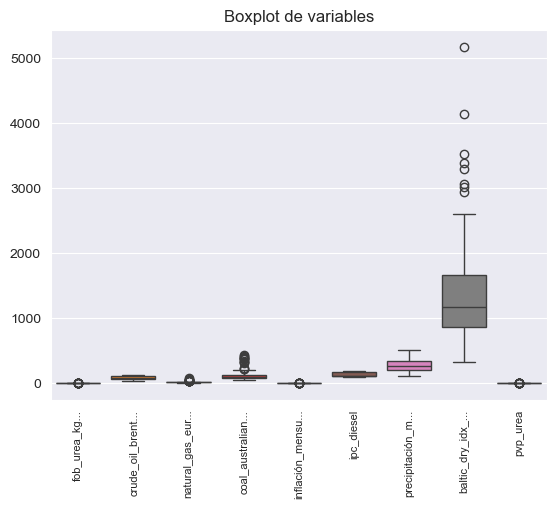

In [412]:
truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in df.columns]
posición_ticks = np.arange(len(df.columns))

sns.boxplot(df)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, rotation=90, size=8)
plt.title("Boxplot de variables")
plt.show()

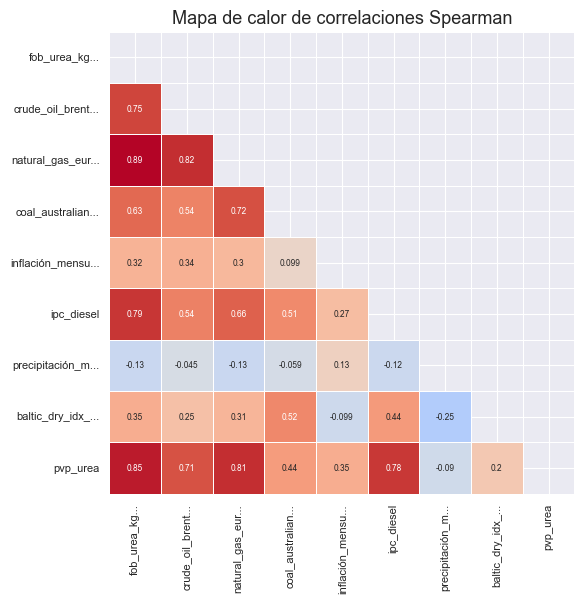

In [413]:
plot_correlation_heatmap(df, method='spearman')

### Ingeniería de variables

In [414]:
# Transformar la precipitación en milímetros a metros:
df['precipitación_media_m'] = df['precipitación_media_mm'] / 1000
df = df.drop(columns=['precipitación_media_mm'])

# Variable de precipitación cuadrada:
df['precipitación_media_m2'] = df['precipitación_media_m'] ** 2

In [415]:
# # Variación absoluta de la pobreza:
# df['var_pct_pobreza_rural'] = df['pct_pobreza_rural'].diff()

In [416]:
# Calcular coeficiente de variación de precipitación y temperatura.
# El coeficiente de variación es una medida de la variabilidad relativa de una serie en relación con su media
vars_coef_variación = {'precipitación':'precipitación_media_m'} # , 'pobreza_rural':'pct_pobreza_rural'} # 'temperatura':'temp_media_Celsius',

for name, var in vars_coef_variación.items():
    df['coef_var_' + name] = df[var].rolling(window=12).std() / df[var].rolling(window=12).mean()

# # Variable de interacción climática:
# df['interacción_climática'] = df['precipitación_media_m'] * df['temp_media_Celsius']

#### Transformación log de variables:

In [417]:
# Crear un DataFrame sin NaN:
df_sin_na = df.dropna()

# Crear DataFrame para variables logarítmicas:
ln_data = pd.DataFrame(index=df_sin_na.index)

# Variables porcentuales:
variables_no_log_transformables = ['inflación_mensual', 'pct_pobreza_rural', 'var_pct_pobreza_rural', 'coef_var_pobreza_rural', 'precipitación_media_m', 'precipitación_media_m2', 'coef_var_precipitación'] #, 'coef_var_temperatura']

variables_log_transformadas = []

# Transformación logarítmica de las variables:
for col in df_sin_na.columns:
    
    # Transformación logarítmica de las variables no transformables:
    if col not in variables_no_log_transformables:
        
        # Añadir a lista de variables log-transformadas:
        variables_log_transformadas.append(col)
        
        # Transformar:
        ln_data['ln_' + col] = df_sin_na[col].apply(np.log)
    else:
        ln_data[col] = df_sin_na[col]

ln_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ln_fob_urea_kg                       132 non-null    float64
 1   ln_crude_oil_brent_usd_per_bbl       132 non-null    float64
 2   ln_natural_gas_europe_usd_per_mmbtu  132 non-null    float64
 3   ln_coal_australian_usd_per_mt        132 non-null    float64
 4   inflación_mensual                    132 non-null    float64
 5   ln_ipc_diesel                        132 non-null    float64
 6   ln_baltic_dry_idx_last               132 non-null    float64
 7   ln_pvp_urea                          132 non-null    float64
 8   precipitación_media_m                132 non-null    float64
 9   precipitación_media_m2               132 non-null    float64
 10  coef_var_precipitación               132 non-null    float64
dtypes: float64(11

### EDA post ingeniería de variables

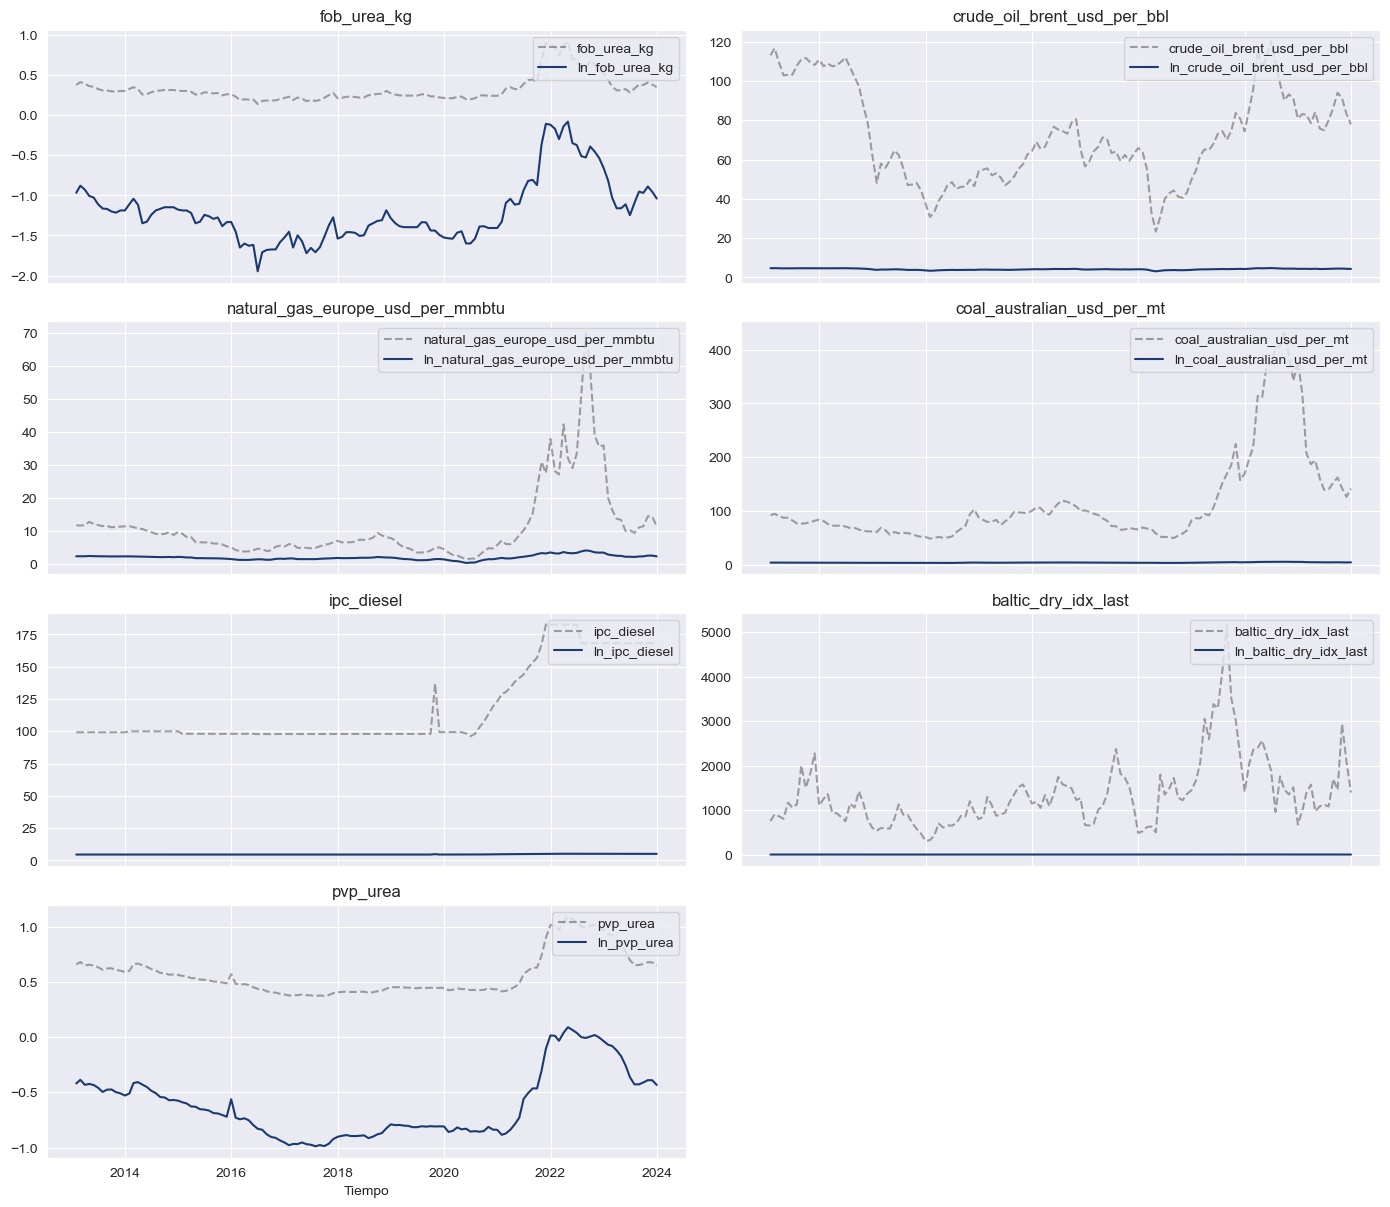

In [418]:
df_variables_log_transformadas = ln_data[["ln_" + col for col in variables_log_transformadas]]
df_variables_log_transformadas.columns = variables_log_transformadas

plot_comparison(df_sin_na[variables_log_transformadas], df_variables_log_transformadas, prefix='ln_')

In [419]:
# Variable objetivo
variable_objetivo = "ln_pvp_urea"

# Variables excluidas en segunda instancia:
variables_excluidas_2 = ['precipitación_media_m', 'precipitación_media_m2'] # , 'inflación_mensual', 'ln_natural_gas_europe_usd_per_mmbtu', 'ln_temp_media_Celsius', 'pct_pobreza_rural'], 'ln_natural_gas_europe_usd_per_mmbtu'
variables_excluidas_2.append(variable_objetivo)

# Extraer variables predictoras:
X = ln_data.drop(columns=variables_excluidas_2)

# Extraer variable objetivo:
y = ln_data[variable_objetivo]

In [420]:
# Calcular el factor de inflación de varianza (VIF) de las variables explicativas originales:
calcular_vif(X)

,Variable,VIF
0,ln_natural_gas_europe_usd_per_mmbtu,10.768284
1,ln_fob_urea_kg,6.500072
2,ln_coal_australian_usd_per_mt,6.210265
3,ln_ipc_diesel,4.796725
4,ln_crude_oil_brent_usd_per_bbl,3.005601
5,ln_baltic_dry_idx_last,1.914442
6,coef_var_precipitación,1.552159
7,inflación_mensual,1.251554


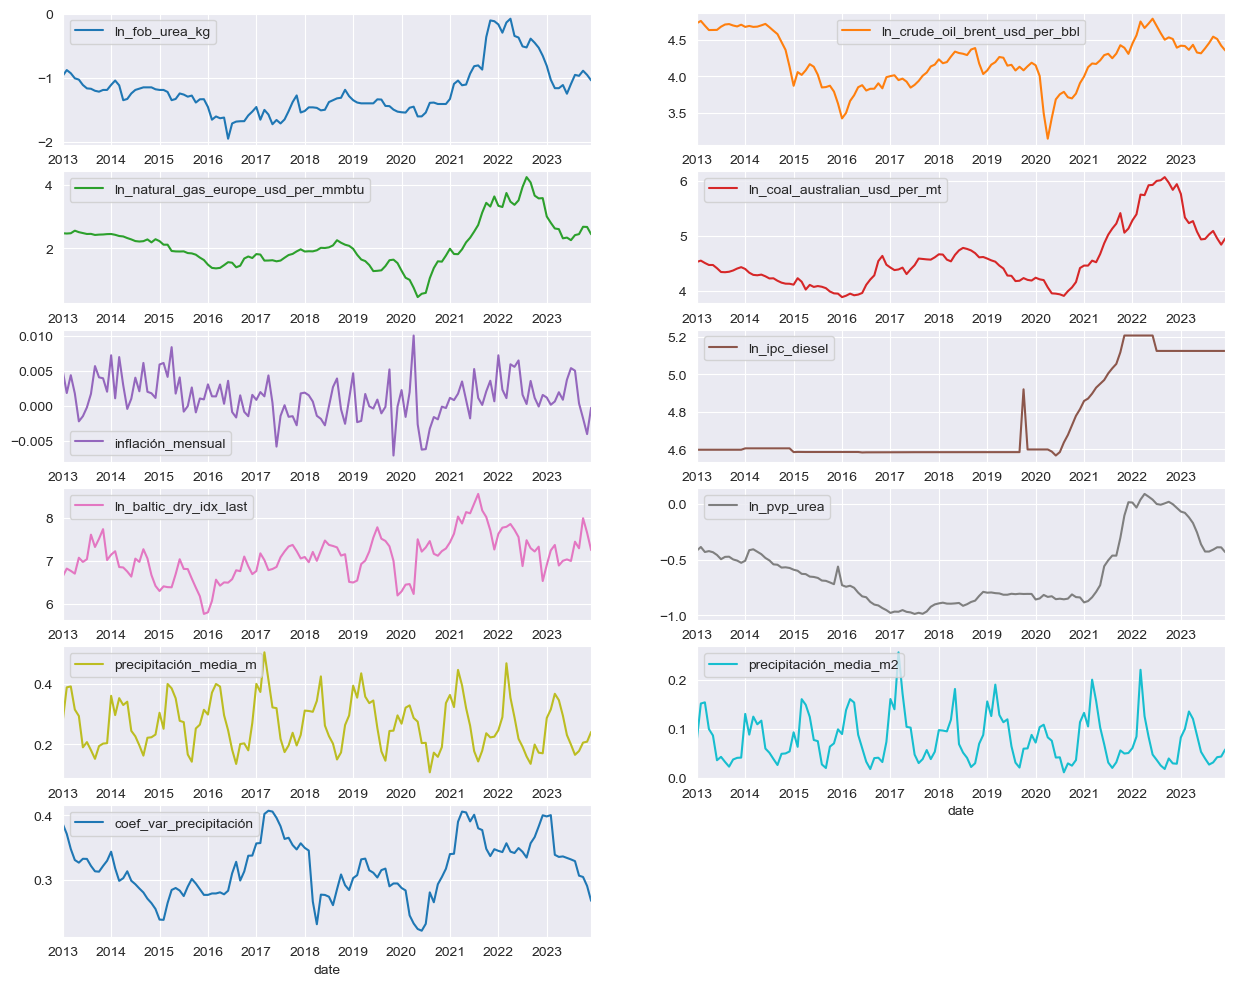

In [421]:
num_de_filas = ((ln_data.shape[1] + 1) // 2)

ln_data.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

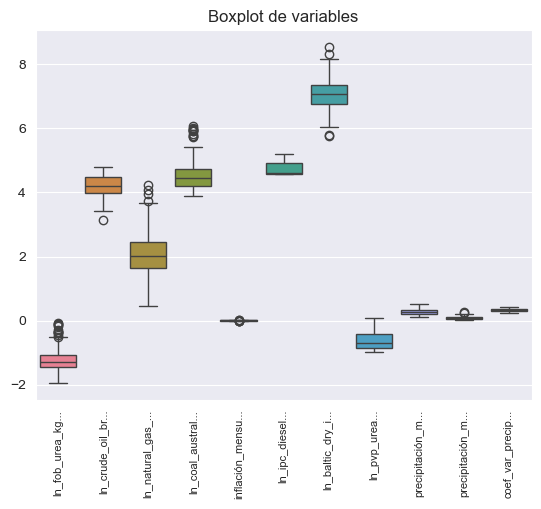

In [422]:
truncated_labels = [col[:15] + "..." if len(col) > 10 else col for col in ln_data.columns]
posición_ticks = np.arange(len(ln_data.columns))

sns.boxplot(ln_data)
plt.xticks(ticks=posición_ticks, labels=truncated_labels, rotation=90, size=8)
plt.title("Boxplot de variables")
plt.show()

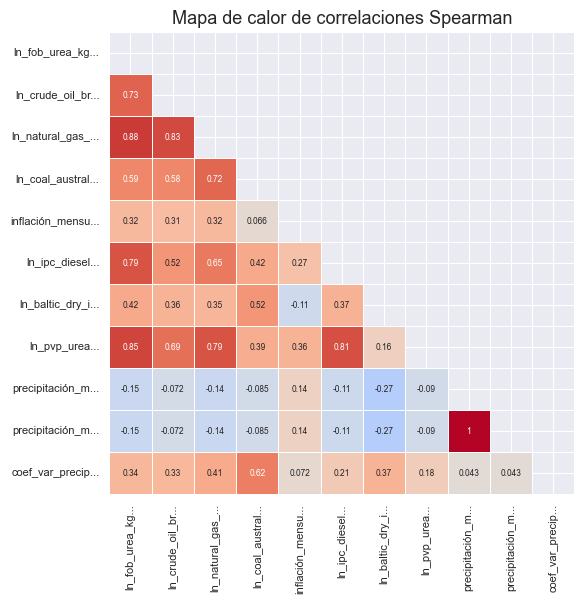

In [423]:
plot_correlation_heatmap(ln_data, method='spearman')

### Regresión Lineal Simple

In [424]:
# Selección automática de variables significativas:
modelo_ols_significativo, variables_significativas_ols = ols_backward_elimination(X, y, significance_level=0.05)

print(modelo_ols_significativo.summary())

variable eliminada: inflación_mensual; p-valor: 0.7825
variable eliminada: ln_coal_australian_usd_per_mt; p-valor: 0.0984
variable eliminada: ln_natural_gas_europe_usd_per_mmbtu; p-valor: 0.2518
                            OLS Regression Results                            
Dep. Variable:            ln_pvp_urea   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     213.7
Date:               mi., 04 dic. 2024   Prob (F-statistic):           9.40e-60
Time:                        15:28:09   Log-Likelihood:                 120.30
No. Observations:                 132   AIC:                            -228.6
Df Residuals:                     126   BIC:                            -211.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
               

In [425]:
# Calcular VIF de las variables significativas del modelo OLS:
calcular_vif(X[variables_significativas_ols])

,Variable,VIF
0,ln_fob_urea_kg,3.899122
1,ln_ipc_diesel,3.276671
2,ln_crude_oil_brent_usd_per_bbl,1.885509
3,ln_baltic_dry_idx_last,1.504493
4,coef_var_precipitación,1.341023


## VECM

### Revisar VIF de variables para VECM

In [426]:
# Seleccionar variables independientes relevantes para el modelo VECM:
X_vecm = ln_data.drop(columns=variables_excluidas_2)

# Revisar VIF de variables para VECM:
print(calcular_vif(X_vecm))

# Adjuntar variable objetivo a variables del modelo VECM:
vars_modelo_vecm = X_vecm.columns.tolist()
vars_modelo_vecm.append(variable_objetivo)

# Crear DataFrame:
df_vars_vecm = ln_data[vars_modelo_vecm]

                              Variable        VIF
0  ln_natural_gas_europe_usd_per_mmbtu  10.768284
1                       ln_fob_urea_kg   6.500072
2        ln_coal_australian_usd_per_mt   6.210265
3                        ln_ipc_diesel   4.796725
4       ln_crude_oil_brent_usd_per_bbl   3.005601
5               ln_baltic_dry_idx_last   1.914442
6               coef_var_precipitación   1.552159
7                    inflación_mensual   1.251554


In [427]:
# plot_scatter_matrix(df_vars_vecm) #, trendline=True)

### Primer supuesto VECM: variables son no estacionarias en niveles (forma original)

In [428]:
# Revisar si las variables son no estacionarias bajo supuesto del modelo VECM:
evaluar_estacionareidad_vars = evaluar_estacionareidad(df_vars_vecm)

evaluar_estacionareidad_vars

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg,2.167094e-01,0.020516,False,True,No estacionario
1,ln_crude_oil_brent_usd_per_bbl,2.125865e-01,0.100000,False,False,No claro
2,ln_natural_gas_europe_usd_per_mmbtu,1.621698e-02,0.070291,True,False,Estacionario
3,ln_coal_australian_usd_per_mt,1.502557e-01,0.010000,False,True,No estacionario
4,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
5,ln_ipc_diesel,9.634624e-01,0.010000,False,True,No estacionario
6,ln_baltic_dry_idx_last,8.641307e-03,0.010000,True,True,No claro
7,coef_var_precipitación,1.305295e-01,0.100000,False,False,No claro
8,ln_pvp_urea,2.561894e-01,0.029500,False,True,No estacionario


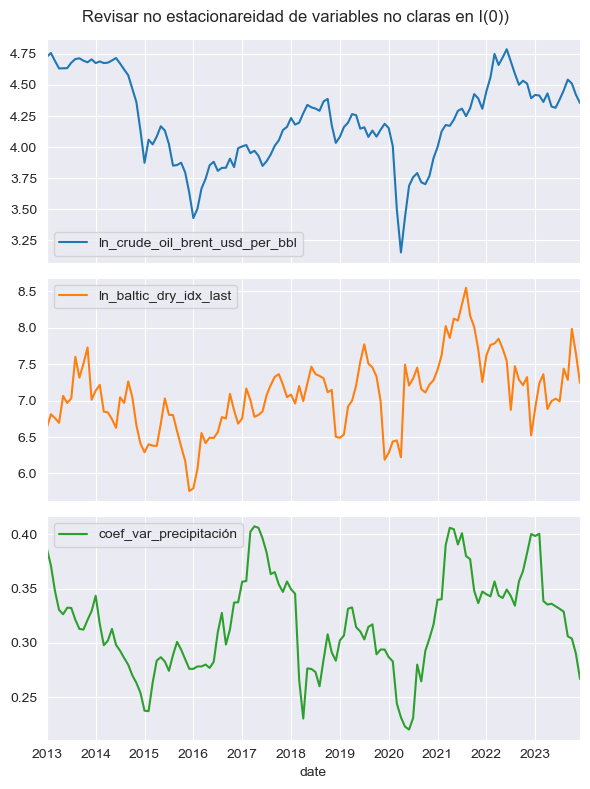

In [429]:
# Filtrar variables con estacionareidad no clara:
estacionareidad_no_clara = df_vars_vecm[evaluar_estacionareidad_vars.query("estado_estacionario == 'No claro'")['variable']]

# Revisar no estacionareidad visualmente:
estacionareidad_no_clara.plot(subplots=True, figsize=(6, 8))
plt.suptitle("Revisar no estacionareidad de variables no claras en I(0))")
plt.tight_layout()
plt.show()

In [430]:
condición = (evaluar_estacionareidad_vars['variable'] == 'coef_var_precipitación')

evaluar_estacionareidad_vars.loc[condición, 'estado_estacionario'] = 'Estacionario'

evaluar_estacionareidad_vars

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg,2.167094e-01,0.020516,False,True,No estacionario
1,ln_crude_oil_brent_usd_per_bbl,2.125865e-01,0.100000,False,False,No claro
2,ln_natural_gas_europe_usd_per_mmbtu,1.621698e-02,0.070291,True,False,Estacionario
3,ln_coal_australian_usd_per_mt,1.502557e-01,0.010000,False,True,No estacionario
4,inflación_mensual,7.021729e-13,0.079594,True,False,Estacionario
5,ln_ipc_diesel,9.634624e-01,0.010000,False,True,No estacionario
6,ln_baltic_dry_idx_last,8.641307e-03,0.010000,True,True,No claro
7,coef_var_precipitación,1.305295e-01,0.100000,False,False,Estacionario
8,ln_pvp_urea,2.561894e-01,0.029500,False,True,No estacionario


**Conclusión 1:** A pesar de que en niveles existen variables con resultado de estacionareidad "no claro", visualmente existe un grado alto de plausibilidad de que estas variables son no estacionarias.

### Segundo supuesto VECM: las variables son estacionarias tras I(1)

In [431]:
# Obtener lista de variables no estacionarias:
variables_no_estacionarias = evaluar_estacionareidad_vars.query("estado_estacionario != 'Estacionario'")['variable'].tolist()

df_diferenciación_I1 = df_vars_vecm[variables_no_estacionarias]\
    .diff()\
    .dropna()\
    .add_suffix("_d1")

# Evaluar si las variables no estacionarias se convierten tras primera diferenciación:
evaluar_estacionareidad_vars_I1 = evaluar_estacionareidad(df_diferenciación_I1)

evaluar_estacionareidad_vars_I1


,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,ln_fob_urea_kg_d1,6.782078e-02,0.1,False,False,No claro
1,ln_crude_oil_brent_usd_per_bbl_d1,3.572860e-13,0.1,True,False,Estacionario
2,ln_coal_australian_usd_per_mt_d1,8.767304e-05,0.1,True,False,Estacionario
3,ln_ipc_diesel_d1,3.881646e-29,0.1,True,False,Estacionario
4,ln_baltic_dry_idx_last_d1,6.231103e-24,0.1,True,False,Estacionario
5,ln_pvp_urea_d1,4.619871e-02,0.1,True,False,Estacionario


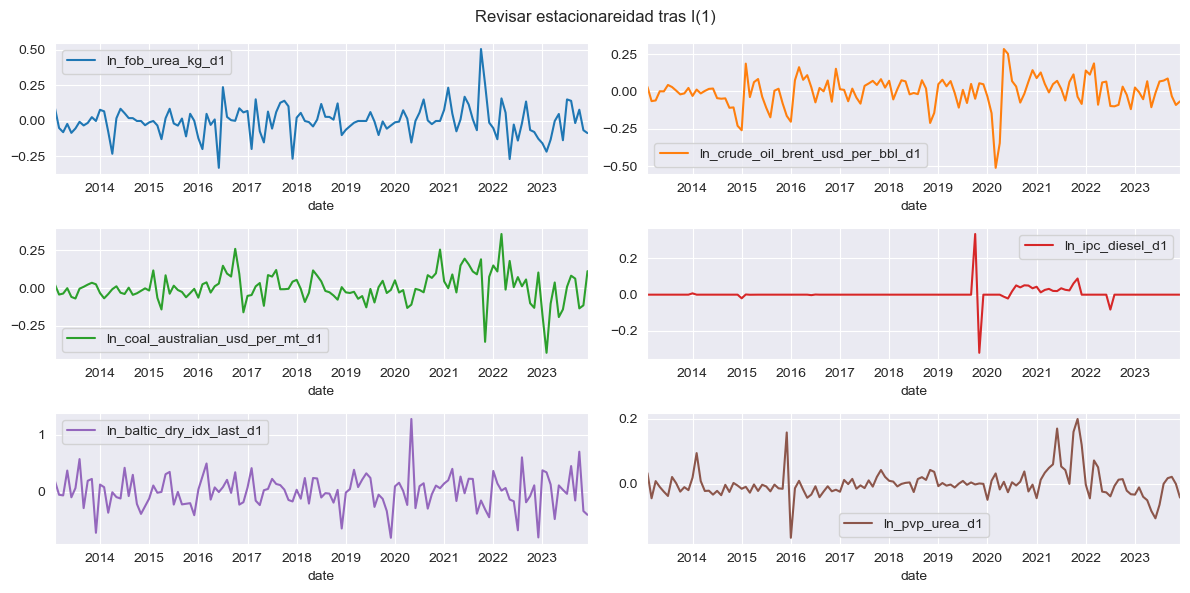

In [432]:
num_de_filas = ((df_diferenciación_I1.shape[1] + 1) // 2)

df_diferenciación_I1.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(12, 2 * num_de_filas),
    sharex=False
    )
plt.suptitle("Revisar estacionareidad tras I(1)")
plt.tight_layout()
plt.show()

**Conclusión:** Aunque algunos resultados de estacionareidad tras I(1) por KPSS y ADF aparecen como "no claros", las gráficas sugieren con alto grado de plausibilidad que todas las variables son estacionarias. Por tanto, se cumple el segundo supuesto del modelo VECM.

### Ruptura estructural

In [433]:
# Crear dataframe solamente con variables no estacionarias:
df_test_cointegración = df_vars_vecm[variables_no_estacionarias]

# Crear dataframe de variables exógenas al modelo de cointegración (en este caso, las variables estacionarias):
set_vars_exógenas = set(df_vars_vecm.columns) - set(variables_no_estacionarias)
df_exógenas_vecm = df_vars_vecm[list(set_vars_exógenas)]

# # Eliminar las variables fertilizantes que no son de interés: 
# columns_to_drop = [col for col in lista_fertilizantes if col != variable_objetivo]

# df_test_cointegración = df_no_estacionarias.drop(columns=columns_to_drop)

print("Variables seleccionadas como exógenas al ser estacionarias: ", set_vars_exógenas)

Variables seleccionadas como exógenas al ser estacionarias:  {'coef_var_precipitación', 'inflación_mensual', 'ln_natural_gas_europe_usd_per_mmbtu'}


In [434]:
# Dividir en variable dependiente e independientes
y = df_test_cointegración[variable_objetivo]
X = df_test_cointegración.drop(columns=[variable_objetivo])

# Detectar rupturas estructurales
ruptura_estructural = detect_structural_breaks(y, X, model_type="l2", n_bkps=3)

# Mostrar resultados
print(ruptura_estructural)

  break_date  F-Statistic       p-value
0 2015-02-28    25.012753  1.882686e-06
1 2016-10-31    56.158173  1.066314e-11
2 2021-05-31    17.028286  6.674297e-05


In [435]:
# Crear DataFrame vacío con el mismo índice que df_test_cointegración:
dummies_ruptura = pd.DataFrame(index=df_test_cointegración.index)

# Ordenar las fechas de ruptura
fechas_ruptura = sorted(pd.to_datetime(ruptura_estructural['break_date'].values))

# Iterar sobre las fechas de ruptura, manejando intervalos entre rupturas
for i, fecha in enumerate(fechas_ruptura):
    # Formatear la fecha para el nombre de la columna
    str_fecha = fecha.strftime('%b%Y').replace(".", "_")
    
    # Definir el fin del intervalo como la siguiente fecha de ruptura o el final del índice
    if i < len(fechas_ruptura) - 1:
        fin_intervalo = fechas_ruptura[i + 1]
    else:
        fin_intervalo = dummies_ruptura.index.max() + pd.Timedelta(days=1)  # Asegura incluir el último día
    
    # Crear la dummy para el intervalo actual
    dummies_ruptura['ruptura_' + str_fecha] = (
        (dummies_ruptura.index >= fecha) & (dummies_ruptura.index < fin_intervalo)
    ).astype(int)

# Unir variables dummy al DataFrame de variables exógenas:
df_exógenas_vecm = df_exógenas_vecm.join(dummies_ruptura, how="inner") 

df_exógenas_vecm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 132 entries, 2013-01-31 to 2023-12-31
Data columns (total 6 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   coef_var_precipitación               132 non-null    float64
 1   inflación_mensual                    132 non-null    float64
 2   ln_natural_gas_europe_usd_per_mmbtu  132 non-null    float64
 3   ruptura_feb_2015                     132 non-null    int32  
 4   ruptura_oct_2016                     132 non-null    int32  
 5   ruptura_may_2021                     132 non-null    int32  
dtypes: float64(3), int32(3)
memory usage: 5.7 KB


### Cointegración

El **Vector AutoRegresivo** (VAR) es un modelo econométrico que captura las relaciones dinámicas entre varias series temporales tratándolas como variables endógenas. A diferencia de modelos univariados, el VAR permite que cada variable dependa de sus propios rezagos y de los rezagos de las demás, sin suponer relaciones causales específicas. Esto lo hace útil para analizar cómo los cambios en una variable afectan a las demás a lo largo del tiempo. Es ideal para identificar patrones de interdependencia y realizar análisis de impacto como impulso-respuesta o descomposición de varianza.

In [436]:
from statsmodels.tsa.api import VAR

# Ajusta un modelo VAR preliminar
modelo_var = VAR(df_test_cointegración, freq='ME')
orden_rezagos = modelo_var.select_order(maxlags=12)
print(orden_rezagos.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.46      -17.32   2.614e-08      -17.40
1       -29.06     -28.08*   2.405e-13     -28.66*
2       -29.19      -27.38  2.117e-13*      -28.45
3       -29.03      -26.38   2.518e-13      -27.95
4       -28.77      -25.28   3.328e-13      -27.35
5       -28.66      -24.34   3.821e-13      -26.91
6       -28.62      -23.46   4.224e-13      -26.52
7       -28.61      -22.62   4.572e-13      -26.18
8       -28.52      -21.69   5.564e-13      -25.75
9       -28.50      -20.84   6.512e-13      -25.39
10      -28.84      -20.34   5.561e-13      -25.39
11      -29.16      -19.83   5.124e-13      -25.37
12     -29.66*      -19.49   4.254e-13      -25.53
--------------------------------------------------


In [437]:
# Obtener el valor de lags óptimo según HQIC:
criterio = 'fpe'
maxlags_óptimo = orden_rezagos.selected_orders[criterio]

print(f"Número de lags óptimo según criterio {criterio.upper()}: ", maxlags_óptimo)

Número de lags óptimo según criterio FPE:  2


La **prueba de Johansen** es un método econométrico utilizado para identificar relaciones de equilibrio a largo plazo (cointegración) entre múltiples series temporales no estacionarias. A diferencia de otros enfoques, como *Engle-Granger*, permite analizar más de dos variables simultáneamente. La prueba utiliza un modelo VAR para evaluar si existe una combinación lineal estacionaria entre las series. Sus resultados indican cuántos vectores de cointegración existen, lo que ayuda a decidir si las variables tienen una relación estable a largo plazo y si se debe utilizar un modelo como el VECM para capturar dichas dinámicas.

In [438]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

cointegración_johansen = coint_johansen(df_test_cointegración, det_order=0, k_ar_diff=maxlags_óptimo)

estadísticos_de_traza = cointegración_johansen.lr1
valores_críticos = cointegración_johansen.cvt

print("Estadísticos de traza:\n", estadísticos_de_traza)
print("Valores críticos:\n[1% | 5% | 10%]\n", valores_críticos)

Estadísticos de traza:
 [123.55667313  70.9239301   36.84893473  16.61327992   5.40208269
   0.2621187 ]
Valores críticos:
[1% | 5% | 10%]
 [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [439]:
# Extraer columna del 5% de nivel de confianza:
valores_críticos_5_pct = valores_críticos[:, 1]  

# Establecer vectores de cointegración base r=0:
r = 0

# Determinar r automáticamente:
for i, (trace, critical) in enumerate(zip(estadísticos_de_traza, valores_críticos_5_pct)):
    if trace > critical:
        # Incrementar r si se rechaza la hipótesis nula:
        r = i + 1

print(f"Número de vectores de cointegración (r): {r}")

Número de vectores de cointegración (r): 2


In [440]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Ajustar el modelo VECM
modelo_vecm = VECM(
    df_test_cointegración,
    exog=df_exógenas_vecm, # Variables estacionarias
    k_ar_diff=maxlags_óptimo,  # Número de rezagos diferenciales basado en el VAR
    coint_rank=r,  # Número de vectores de cointegración, según Johansen
    deterministic='cili',
    freq='ME'
    ).fit()

# Resumen del modelo
print(modelo_vecm.summary())

    Det. terms outside the coint. relation & lagged endog. parameters for equation ln_fob_urea_kg    
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
exog1                                 0.1531      0.165      0.930      0.352      -0.170       0.476
exog2                                 0.2833      3.373      0.084      0.933      -6.328       6.895
exog3                                 0.1300      0.039      3.357      0.001       0.054       0.206
exog4                                -0.0200      0.032     -0.632      0.527      -0.082       0.042
exog5                                 0.0626      0.045      1.378      0.168      -0.026       0.152
exog6                                 0.0874      0.035      2.511      0.012       0.019       0.156
L1.ln_fob_urea_kg                    -0.0029      0.101     -0.029      0.977     

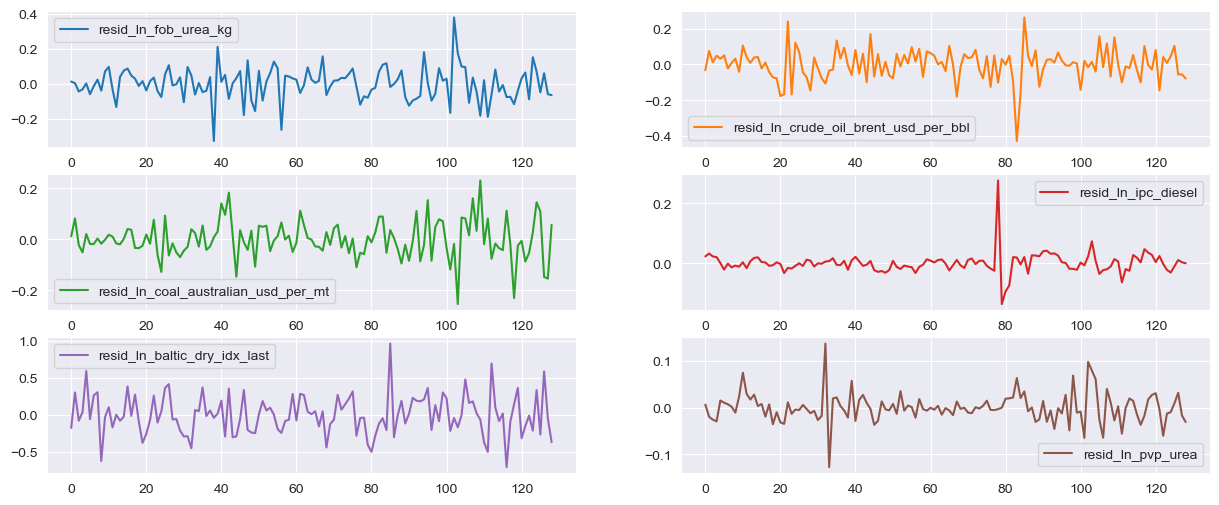

In [441]:
residuos_vecm = pd.DataFrame()

for var_name, resid in zip(df_test_cointegración.columns, modelo_vecm.resid.T):
    residuos_vecm["resid_" + var_name] = resid

num_de_filas = ((residuos_vecm.shape[1] + 1) // 2)

residuos_vecm.plot(
    subplots=True,
    layout=(num_de_filas, 2), # filas, columnas
    figsize=(15, 2 * num_de_filas),
    sharex=False
    )
plt.show()

En un modelo VECM, la estacionariedad de los residuos es esencial para garantizar que las relaciones entre las variables estén correctamente especificadas y que el modelo no omita dinámicas importantes. Si los residuos no son estacionarios, esto podría indicar la presencia de patrones no capturados, como tendencias o ciclos, lo que comprometería la validez de las inferencias realizadas. Además, la estacionariedad previene problemas como las relaciones espurias, asegurando que las estimaciones reflejen vínculos económicos reales y no coincidencias estadísticas.

La evaluación conjunta de estacionariedad mediante las pruebas **Augmented Dickey-Fuller** (ADF) y **Kwiatkowski-Phillips-Schmidt-Shin** (KPSS) permite obtener una perspectiva más completa sobre la naturaleza de las series temporales. Estas pruebas abordan la estacionariedad desde enfoques opuestos: ADF detecta la presencia de raíces unitarias (es decir, no estacionariedad) asumiendo como hipótesis nula que la serie no es estacionaria, mientras que KPSS evalúa si existe tendencia o estructura no estacionaria, partiendo de la hipótesis nula de que la serie es estacionaria.

La combinación de ambos resultados facilita una evaluación robusta de la estacionareidad de los residuos. Una serie se considera estacionaria si ADF rechaza su hipótesis nula (p-valor bajo) y KPSS no la rechaza (p-valor alto). Por el contrario, se considera no estacionaria si ADF no rechaza su hipótesis nula (p-valor alto) o KPSS sí la rechaza (p-valor bajo). Este enfoque evita depender únicamente de un test, aumentando la precisión y confiabilidad del análisis.

In [442]:
# Evaluar estacionareidad de residuos del modelo VECM utilizando ADF y KPSS:
evaluar_estacionareidad_residuos_vecm = evaluar_estacionareidad(residuos_vecm)

evaluar_estacionareidad_residuos_vecm

,variable,valor_p_adfuller,valor_p_kpss,adfuller_rechazar_H0,kpss_rechazar_H0,estado_estacionario
0,resid_ln_fob_urea_kg,4.149844e-05,0.1,True,False,Estacionario
1,resid_ln_crude_oil_brent_usd_per_bbl,1.750739e-22,0.1,True,False,Estacionario
2,resid_ln_coal_australian_usd_per_mt,1.067938e-18,0.1,True,False,Estacionario
3,resid_ln_ipc_diesel,5.276827e-21,0.1,True,False,Estacionario
4,resid_ln_baltic_dry_idx_last,2.994035e-20,0.1,True,False,Estacionario
5,resid_ln_pvp_urea,1.055227e-22,0.1,True,False,Estacionario


La **prueba de Ljung-Box** evalúa si los residuos de un modelo de series temporales son independientes, es decir, si no presentan autocorrelación. La independencia de los residuos garantiza que el modelo haya capturado adecuadamente las dinámicas de las variables y no existan patrones no modelados.

La hipótesis nula de la prueba plantea que no hay autocorrelación en los residuos, mientras que la hipótesis alternativa sugiere lo contrario. Un p-valor alto indica que los residuos son independientes, mientras que un p-valor bajo señala la presencia de autocorrelación y la posible necesidad de ajustar el modelo.

En modelos como el VECM, la prueba de Ljung-Box es clave para confirmar que las relaciones temporales han sido correctamente especificadas y que las inferencias basadas en el modelo son confiables.

In [443]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Crear un diccionario para almacenar los resultados
resultados_ljung_box = {}

# Iterar sobre cada columna (variable) del DataFrame de residuos
for column in residuos_vecm.columns:
    ljung_box = acorr_ljungbox(residuos_vecm[column], lags=10, return_df=True)  # Ajustar número de lags según sea necesario
    resultados_ljung_box[column] = ljung_box

# Convertir los resultados en un DataFrame para mejor visualización
df_ljung_box = pd.concat(resultados_ljung_box, axis=1)

# Mostrar los resultados
df_ljung_box


resid_ln_fob_urea_kg           resid_ln_crude_oil_brent_usd_per_bbl  \
                lb_stat lb_pvalue                              lb_stat   
1              0.456162  0.499423                             0.831020   
2              0.506345  0.776334                             0.831189   
3              0.595875  0.897376                             1.929232   
4              1.476772  0.830748                             2.390745   
5              1.651952  0.894896                             2.431197   
6              3.816587  0.701481                             2.449157   
7              8.973175  0.254588                             2.574677   
8             13.095648  0.108601                             2.574972   
9             18.237755  0.032513                             2.582988   
10            20.231991  0.027133                             2.857334   

             resid_ln_coal_australian_usd_per_mt            \
   lb_pvalue                             lb_stat lb_pvalue   
1   0.361978                            0.537272  0.463565   
2   0.659948                            0.580165  0.748202   
3   0.587224                            0.592583  0.898128   
4   0.664300                            3.078310  0.544807   
5   0.786819                            3.312855  0.651874   
6   0.874114                            7.819630  0.251618   
7   0.921370                            8.005556  0.332104   
8   0.958143                            9.351516  0.313516   
9   0.978568                            9.586251  0.385006   
10  0.984585                           10.838681  0.370224   

   resid_ln_ipc_diesel           resid_ln_baltic_dry_idx_last            \
               lb_stat lb_pvalue                      lb_stat lb_pvalue   
1             0.052884  0.818119                     0.000115  0.991460   
2             0.697945  0.705413                     0.000138  0.999931   
3             2.443642  0.485562                     0.026134  0.998885   
4             2.736689  0.602810                     6.672960  0.154214   
5             2.868585  0.720238                     7.347223  0.196071   
6             3.393375  0.758097                     8.461344  0.206214   
7             3.595340  0.825026                     8.475842  0.292508   
8             6.640284  0.575893                     8.523336  0.384086   
9             7.104874  0.626201                     9.158292  0.422793   
10            7.259411  0.700749                     9.420553  0.492710   

   resid_ln_pvp_urea            
             lb_stat lb_pvalue  
1           1.035654  0.308834  
2           1.038122  0.595079  
3           2.664667  0.446265  
4           2.746356  0.601128  
5           5.077580  0.406486  
6           5.154455  0.524161  
7           5.339914  0.618557  
8           8.509260  0.385367  
9          12.307283  0.196535  
10         12.313969  0.264593

### Revisar homocedasticidad

In [444]:
for col in ln_data.columns:

    # Calcular estadísticos de heterocedasticidad:
    lm_stat, p_value = check_homoscedasticity(ln_data[col])
    
    # Imprimir estadísticos:
    print(f"{col} ->  p-value: {p_value}")
    
    # Filtrar variables con evidencia de heterocedasticidad:

ln_fob_urea_kg ->  p-value: 0.0
ln_crude_oil_brent_usd_per_bbl ->  p-value: 0.626
ln_natural_gas_europe_usd_per_mmbtu ->  p-value: 0.0
ln_coal_australian_usd_per_mt ->  p-value: 0.0
inflación_mensual ->  p-value: 0.652
ln_ipc_diesel ->  p-value: 0.0
ln_baltic_dry_idx_last ->  p-value: 0.0
ln_pvp_urea ->  p-value: 0.034
precipitación_media_m ->  p-value: 0.246
precipitación_media_m2 ->  p-value: 0.412
coef_var_precipitación ->  p-value: 0.005


In [445]:
# plot_ccf_subplots(df_estacionarios, X.columns.tolist(), variable_objetivo, max_lag=30, palette_name="tab20")